In [120]:
import torch
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
from scipy.spatial.distance import cdist
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import random

In [121]:
def RVSML_OT_Learning(traindataset, templatenum, lambda_val, delta = 1, max_nIter = 20, err_limit = 1.0e-6):
    lambda1=torch.tensor(0.1, requires_grad=True)
    lambda2=torch.tensor(10.0, requires_grad=True)
    learning_rate = 1e-1 #thay đổi lớn hơn
    optimizer = torch.optim.Adam([lambda1, lambda2], learning_rate)
    mini_batch = 6
    batch_size = 110
    
    for count in range(mini_batch):
        i = count * batch_size
        trainset = []
        trainset_cell = []
        # trainsetnum = []
        
        while (i < len(traindataset)):
            trainset_cell.append(traindataset[i])
            i += 1
            if i % batch_size == 0:
                trainset.append(trainset_cell)
                # trainsetnum.append(len(trainset_cell))
                trainset_cell = []
                i += 660
        classnum = len(trainset)
        downdim = classnum * templatenum
        dim = len(trainset[0][0][0])
        traindownset = [None] * classnum

        trainsetnum = [0] * classnum
        virtual_sequence = [None] * classnum
        active_dim = 0

        for c in range(classnum):
            trainsetnum[c] = len(trainset[c])
            virtual_sequence[c] = torch.zeros((templatenum, downdim))
            for a_d in range(0, templatenum-1):
                active_dim += 1
                virtual_sequence[c][a_d][active_dim] = 1

        R_A = torch.zeros((dim, dim))
        R_B = torch.zeros((dim, downdim))
        N = sum(trainsetnum)
        for c in range(classnum):
            for n in range(trainsetnum[c]):
                seqlen = len(trainset[c][n])
                T_ini = torch.ones((seqlen, templatenum)) / (seqlen * templatenum)
                for i in range(seqlen):
                    trainset[c][n][i] = torch.tensor(trainset[c][n][i])
                    temp_ra = torch.ger(trainset[c][n][i], trainset[c][n][i])
                    for j in range(templatenum):
                        R_A += T_ini[i, j] * temp_ra
                        R_B += T_ini[i, j] * torch.ger(trainset[c][n][i], virtual_sequence[c][j])
                trainset[c][n] = torch.stack(trainset[c][n])

        R_I = R_A + lambda_val * N * torch.eye(dim)
        L = torch.linalg.solve(R_I, R_B)

        loss_old = 1e8
        values_loss = []

        for nIter in range(max_nIter):
            loss = 0
            R_T = 0
            R_A = torch.zeros((dim, dim))
            R_B = torch.zeros((dim, downdim))
            N = np.sum(trainsetnum)
        
            for c in range(classnum):
                traindownset[c] = [None] * trainsetnum[c]
                for n in range(trainsetnum[c]):
                    seqlen = len(trainset[c][n])
                    
                    traindownset[c][n] = torch.matmul(trainset[c][n], L)
                    dist, T, R = OPW(torch.matmul(trainset[c][n], L), virtual_sequence[c], verbose=0, lambda1=lambda1, lambda2=lambda2)
                    # print(torch.tensor(T).shape)
                    # values_T.append(torch.tensor(T).numpy)
                    R_T += R
                    with torch.no_grad():
                        loss += dist
                    
                        for i in range(seqlen):
                            temp_ra = torch.ger(trainset[c][n][i], trainset[c][n][i])
                            for j in range(templatenum):
                                
                                R_A += ((T[i, j] * temp_ra))
                                R_B += (T[i, j] * torch.ger(trainset[c][n][i], virtual_sequence[c][j]))

            
            loss = loss / N + torch.trace(torch.matmul(L.t(), L)) + R_T / N
            values_loss.append(loss.detach().numpy())
            if abs(loss - loss_old) < err_limit:
                break
            else:
                loss_old = loss
            print(loss)
            
            with torch.no_grad():
                R_I = R_A + lambda_val * N * torch.eye(dim)
                L = torch.linalg.solve(R_I, R_B)
                
            # cải tiến: kĩ thuật backward để cập nhật giá trị của tham số theo hàm loss    
            loss.backward()
            optimizer.step()
            print(lambda1)
            print(lambda2)
            
        print(values_loss)
        plt.plot(values_loss)
        plt.xlabel('Step/Epoch')
        plt.ylabel('Values_Loss')
        plt.title('Values_Loss over Steps/Epochs')
        plt.show() 
        count += 1
    
    return L, lambda1, lambda2, classnum, trainset, trainsetnum


In [122]:
def OPW(x: torch.Tensor, y: torch.Tensor, a: torch.Tensor = None, b: torch.Tensor = None, std=1, verbose=0, lambda1=0.1, lambda2=10,
          tol=.5e-2, maxIter=20, p_norm='inf', metric='sqreuclidean'):
          
    assert y.size(1) == x.size(1), "The dimensions of instances in the input sequences must be the same!"
    N = x.size(0)
    M = y.size(0)
    col_x = torch.arange(1, N+1)/N
    col_x = col_x.view(N, 1)
    col_y = torch.arange(1, M+1)/M
    relative_pos = col_x-col_y

    l = torch.abs(relative_pos) / ((1/N**2 + 1/M**2)**0.5)
    P = torch.exp(-l**2/(2*std**2)) / (std*(2*np.pi)**0.5)

    S = lambda1 / (relative_pos**2 + 1)

    D = pdist2(x, y, metric=metric)

    K = P * torch.exp((S - D) / lambda2)

    if a is None:
        a = torch.ones(N, 1) / N

    ainvK = K / a   # [N, M]

    iter = 0
    u = torch.ones(N, 1) / N

    if b is None:
        b = torch.ones(M, 1) / M
    while iter < maxIter:

        # Perform the operations
        K_transpose = K.t()
        temp = b / torch.matmul(K_transpose, u)
        temp2 = torch.matmul(ainvK, temp)
        u = 1.0 / temp2
        
        iter += 1
        if iter % 20 == 1 or iter == maxIter:
            v = b / torch.matmul(K.T, u)    # [M, 1]
            u = 1 / torch.matmul(ainvK, v)  # [N, 1]

            criterion = torch.sum(torch.abs(v * torch.matmul(K.T, u) - b), dim=0)
            criterion = criterion.norm(p=float(p_norm))
            if abs(criterion) < tol:
                break

            iter += 1
            if verbose > 0:
                print(f"Iteration : {iter}, Criterion: {criterion}")
    
    U = K * D   # [N, M]
    
    dist = torch.sum(u.double() * torch.matmul(U.double(), v.double()), dim=0)
    T = v.T.double() * (u.double() * K.double())
    
    R = 0
    for i in range(N):
        for j in range(M):
            R = R -lambda1 * T[i][j] / ((i/N + j/M)**2 + 1) + lambda2 * T[i][j] * torch.log(T[i][j]/P[i][j])
 
    return dist, T, R

In [123]:
def pdist2(X, Y, metric='sqreuclidean'):
    if metric.lower() == 'sqreuclidean':
        return distEucSqr(X, Y)
    elif metric.lower() == 'euclidean':
        return torch.sqrt(distEucSqr(X, Y))
    elif metric.lower() == 'L1':
        return distL1(X, Y)
    elif metric.lower() == 'cosine':
        return distCosine(X, Y)
    elif metric.lower() == 'emd':
        return distEmd(X, Y)
    elif metric.lower() == 'chisqr':
        return distChiSqr(X, Y)
    else:
        raise NotImplementedError(f'pdist - unknown metric: {metric}')


def distL1(x: torch.Tensor, y: torch.Tensor):
    return torch.abs(x.unsqueeze(1) - y).sum(dim=-1)


def distCosine(x: torch.Tensor, y: torch.Tensor, eps=1e-8):
    assert x.dtype == torch.float or y.dtype == torch.float, "Inputs must be of type float"
    cos = torch.nn.CosineSimilarity(dim=-1, eps=eps)
    return 1 - cos(x.unsqueeze(1), y)


def distEmd(x: torch.Tensor, y: torch.Tensor):
    x_cdf = torch.cumsum(x, dim=-1)
    y_cdf = torch.cumsum(y, dim=-1)

    return torch.abs(x_cdf.unsqueeze(1) - y_cdf).sum(dim=-1)


def distEucSqr(x: torch.Tensor, y: torch.Tensor):
    return torch.cdist(x, y, p=2)**2


def distChiSqr(x: torch.Tensor, y: torch.Tensor, eps=1e-10):
    a = x.unsqueeze(1) + y
    b = x.unsqueeze(1) - y
    return (b**2 / (a + eps)).sum(dim=-1) / 2

In [124]:
from sklearn.preprocessing import OneHotEncoder

def NNClassifier(classnum, trainset, trainsetnum, testsetdata, testsetdatanum, testsetlabel, 
                 lambda1, lambda2, delta = 1):

    trainsetdatanum = sum(trainsetnum)
    trainsetdata =  [None] * trainsetdatanum
    trainsetlabel = torch.zeros((trainsetdatanum, 1))
    sample_count = 0

    for c in range(classnum):
        for per_sample_count in range(trainsetnum[c]):
            trainsetdata[sample_count] = trainset[c][per_sample_count]
            trainsetlabel[sample_count] = c
            sample_count += 1
            

    # def getLabel(classid):
    #     X = torch.zeros((len(classid), torch.max(classid))) - 1
    #     for i in range(1, torch.max(classid) + 1):
    #         indx = torch.where(classid == i)[0]
    #         X[indx, i-1] = 1
    #     return X
    testsetlabelori = testsetlabel.clone()
    # testsetlabel = getLabel(testsetlabelori)
    # trainsetlabelfull = getLabel(trainsetlabel)
    
    encoder = OneHotEncoder(sparse=False)
    
    testsetlabel_reshaped = testsetlabel.reshape(-1,1)
    trainsetlabel_reshaped = trainsetlabel.reshape(-1,1)
    
    testsetlabel = encoder.fit_transform(testsetlabel_reshaped)
    trainsetlabelfull = encoder.fit_transform(trainsetlabel_reshaped)
    print(trainsetlabelfull[0])

    k_pool = [1, 3, 5, 7, 9, 11, 15, 30]
    k_num = len(k_pool)
    Acc = torch.zeros((k_num, 1))

    start_time = time.time()

    dis_totrain_scores = torch.zeros((trainsetdatanum, testsetdatanum))
    ClassLabel = torch.arange(0, classnum)
    dis_ap = torch.zeros(testsetdatanum)

    rightnum = torch.zeros(k_num, 1)
    for j in range(testsetdatanum):
        testsetdata[j] = torch.tensor(testsetdata[j])
        for m2 in range(trainsetdatanum):
            # [Dist, D, matchlength, w] = dtw2(trainsetdata[m2].T, testsetdata[j].T)
            # [Dist, T] = Sinkhorn_distance(trainsetdata[m2], testsetdata[j], lambda, 0)
            
            [Dist, T, R] = OPW(torch.tensor(trainsetdata[m2]), testsetdata[j], lambda1=lambda1, lambda2 = lambda2)
            dis_totrain_scores[m2, j] = Dist
            if torch.isnan(Dist):
                print('Not a number!')
        
        distm, index = torch.sort(dis_totrain_scores[:, j])
        
        for k_count in range(k_num):
            cnt = torch.zeros(classnum, 1)
            for temp_i in range(k_pool[k_count]):
                ind = torch.where(ClassLabel == trainsetlabel[index[temp_i]])[0][0]
                cnt[ind] += 1
            distm2, ind = torch.max(cnt), torch.argmax(cnt)
            predict = ClassLabel[ind]
            predict = predict.item()
            if predict == testsetlabelori[j]:
                rightnum[k_count] += 1
        
        temp_dis = -dis_totrain_scores[:, j]
        temp_dis[torch.isnan(temp_dis)] = 0
        average_precision = average_precision_score(trainsetlabelfull[:, testsetlabelori[j]], temp_dis.detach().numpy())
        dis_ap[j] = average_precision
        
        Acc = rightnum / testsetdatanum
        Map = torch.mean(dis_ap)

        knn_time = time.time() - start_time
        knn_averagetime = knn_time / testsetdatanum

    return Map, Acc, knn_averagetime


In [125]:
def get_utterances(path):
  X = []
  utterances = []
  count = 0
  with open(path, 'r') as f:
      length_X = len([line for line in f.read().splitlines()])
  with open(path, 'r') as f:
      for line in f.read().splitlines():
          count += 1
          frame = [-abs(float(i)) if i.startswith('-') else abs(float(i)) for i in line.split()]
          if len(frame) > 0:
            utterances.append(frame)
            if count == length_X:
              X.append(utterances)
          else:
            if len(utterances) > 0:
              X.append(utterances)
              utterances = []
          # if len(X) == 660*2: 
          #    break
  return X

In [126]:
X_train = get_utterances(path="E:/Documents/Tài liệu học tập/DS Lab/OT/OWD/data sets/Train_Arabic_Digit.txt")
X_test = get_utterances(path="E:/Documents/Tài liệu học tập/DS Lab/OT/OWD/data sets/Test_Arabic_Digit.txt")
print(f"Number of training sample: {len(X_train)}")
print(f"Number of testing sample: {len(X_test)}")


Number of training sample: 6600
Number of testing sample: 2200


In [127]:
import torch
import numpy as np
import json 

n_class = torch.Tensor(torch.arange(0, 10)).view(10, 1)
y_train = n_class.expand_as(torch.empty((10, 660))).contiguous().view(6600)
y_test = n_class.expand_as(torch.empty((10, 220))).contiguous().view(2200)

In [128]:
y_train

tensor([0, 0, 0,  ..., 9, 9, 9])

In [129]:
with open('fe.json', 'w') as f:
    json.dump(3, f)

In [130]:
# dataset = [(data_sample, class_label) for data_sample, class_label in zip(X_train, y_train)]

# # Dictionary to store the selected samples
# selected_samples = {class_label: [] for class_label in range(10)}

# # Iterate over each class
# for class_label in range(10):
#     # Filter the dataset for the current class
#     filtered_data = [sample for sample in dataset if sample[1] == class_label]
    
#     # Randomly select 100 samples from the filtered dataset
#     selected_samples[class_label] = random.sample(filtered_data, 660)

# # Print the selected samples
# # for class_label, samples in selected_samples.items():
# #     print(f"Class {class_label}:")
# #     for sample in samples:
# #         print(sample)
#     # print()

In [131]:
# testsetdata = X_test
# testsetlabel = y_test
# testsetdatanum = 50

# trainsetdata = []
# trainsetlabel = []
# for class_label, samples in selected_samples.items():
#     for sample in samples:
#         trainsetdata.append(sample[0])
#         trainsetlabel.append(sample[1])

# trainsetdatanum = len(trainsetdata)




In [132]:
# trainset = []
# trainset_cell = []
# trainsetnum = []

# for i, data_point in enumerate(trainsetdata, 1):
#     trainset_cell.append(data_point)

#     if i % 660 == 0 or i == len(X_train):
#         trainset.append(trainset_cell)
#         trainsetnum.append(len(trainset_cell))
#         trainset_cell = []


tensor([-32.4122], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2000, requires_grad=True)
tensor(10.1000, requires_grad=True)
tensor([-32.7994], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2965, requires_grad=True)
tensor(10.1965, requires_grad=True)
tensor([-33.1774], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.3923, requires_grad=True)
tensor(10.2923, requires_grad=True)
tensor([-33.5527], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.4884, requires_grad=True)
tensor(10.3884, requires_grad=True)
tensor([-33.9290], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.5851, requires_grad=True)
tensor(10.4851, requires_grad=True)
tensor([-34.3080], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.6827, requires_grad=True)
tensor(10.5827, requires_grad=True)
tensor([-34.6906], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.7814, requires_grad=True)
tensor(10.6814, requires_grad=True)
tensor([-35.0773], dtype=torch.float64, grad_fn=<AddBac

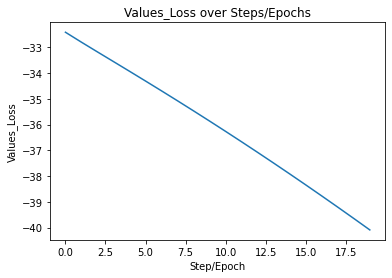

tensor([-41.2689], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2.2919, requires_grad=True)
tensor(12.1919, requires_grad=True)
tensor([-41.7288], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2.4089, requires_grad=True)
tensor(12.3089, requires_grad=True)
tensor([-42.1939], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2.5270, requires_grad=True)
tensor(12.4270, requires_grad=True)
tensor([-42.6636], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2.6462, requires_grad=True)
tensor(12.5462, requires_grad=True)
tensor([-43.1377], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2.7664, requires_grad=True)
tensor(12.6665, requires_grad=True)
tensor([-43.6161], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2.8877, requires_grad=True)
tensor(12.7879, requires_grad=True)
tensor([-44.0988], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3.0101, requires_grad=True)
tensor(12.9103, requires_grad=True)
tensor([-44.5856], dtype=torch.float64, grad_fn=<AddBac

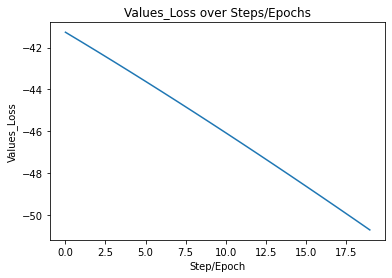

tensor([-50.7964], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4.8182, requires_grad=True)
tensor(14.7202, requires_grad=True)
tensor([-51.3249], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4.9533, requires_grad=True)
tensor(14.8554, requires_grad=True)
tensor([-51.8584], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5.0890, requires_grad=True)
tensor(14.9913, requires_grad=True)
tensor([-52.3947], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5.2254, requires_grad=True)
tensor(15.1279, requires_grad=True)
tensor([-52.9336], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5.3624, requires_grad=True)
tensor(15.2651, requires_grad=True)
tensor([-53.4749], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5.5000, requires_grad=True)
tensor(15.4029, requires_grad=True)
tensor([-54.0187], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5.6383, requires_grad=True)
tensor(15.5414, requires_grad=True)
tensor([-54.5649], dtype=torch.float64, grad_fn=<AddBac

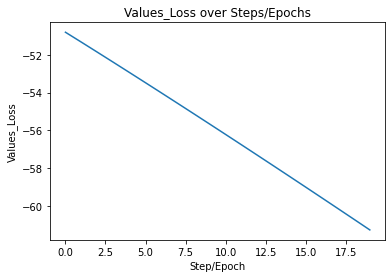

tensor([-61.7591], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.6277, requires_grad=True)
tensor(17.5329, requires_grad=True)
tensor([-62.3274], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.7731, requires_grad=True)
tensor(17.6785, requires_grad=True)
tensor([-62.9008], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7.9189, requires_grad=True)
tensor(17.8244, requires_grad=True)
tensor([-63.4757], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.0651, requires_grad=True)
tensor(17.9706, requires_grad=True)
tensor([-64.0521], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.2116, requires_grad=True)
tensor(18.1172, requires_grad=True)
tensor([-64.6298], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.3584, requires_grad=True)
tensor(18.2642, requires_grad=True)
tensor([-65.2089], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.5056, requires_grad=True)
tensor(18.4115, requires_grad=True)
tensor([-65.7893], dtype=torch.float64, grad_fn=<AddBac

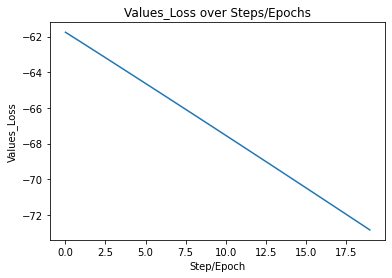

tensor([-73.5715], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10.5968, requires_grad=True)
tensor(20.5037, requires_grad=True)
tensor([-74.1655], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10.7481, requires_grad=True)
tensor(20.6551, requires_grad=True)
tensor([-74.7628], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10.8996, requires_grad=True)
tensor(20.8066, requires_grad=True)
tensor([-75.3609], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11.0513, requires_grad=True)
tensor(20.9584, requires_grad=True)
tensor([-75.9599], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11.2032, requires_grad=True)
tensor(21.1103, requires_grad=True)
tensor([-76.5597], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11.3553, requires_grad=True)
tensor(21.2625, requires_grad=True)
tensor([-77.1603], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11.5076, requires_grad=True)
tensor(21.4148, requires_grad=True)
tensor([-77.7617], dtype=torch.float64, grad_fn=

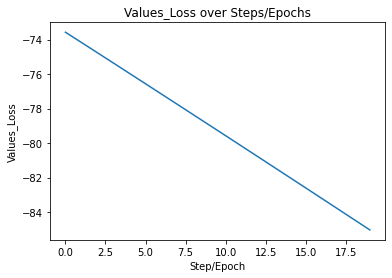

tensor([-84.5448], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13.6584, requires_grad=True)
tensor(23.5662, requires_grad=True)
tensor([-85.1394], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13.8132, requires_grad=True)
tensor(23.7210, requires_grad=True)
tensor([-85.7431], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13.9682, requires_grad=True)
tensor(23.8760, requires_grad=True)
tensor([-86.3475], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14.1232, requires_grad=True)
tensor(24.0311, requires_grad=True)
tensor([-86.9523], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14.2784, requires_grad=True)
tensor(24.1863, requires_grad=True)
tensor([-87.5576], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14.4337, requires_grad=True)
tensor(24.3416, requires_grad=True)
tensor([-88.1635], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14.5892, requires_grad=True)
tensor(24.4971, requires_grad=True)
tensor([-88.7697], dtype=torch.float64, grad_fn=

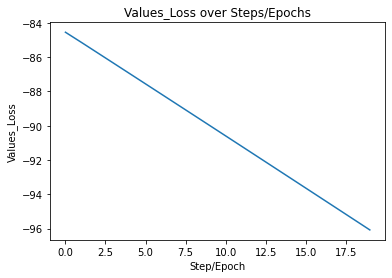

<class 'torch.Tensor'>


In [133]:
testsetdata = X_test
testsetlabel = y_test
testsetdatanum = 1000

trainset = X_train

classnum = 10
dim = 40
CVAL = 1

templatenum = 4     
lambda_val = 0.01
start_time = time.time()

testdownsetdata = [None] * testsetdatanum

L, lambda1, lambda2, classnum, trainset1, trainsetnum = RVSML_OT_Learning(trainset, templatenum, lambda_val, delta = 1, max_nIter = 20, err_limit = 1.0e-6)

for j in range(testsetdatanum):
    testsetdata[j] = torch.tensor(testsetdata[j])
    testdownsetdata[j] = torch.matmul(testsetdata[j], L)
RVSML_opw_time = time.time() - start_time
print(type(trainset[0][0]))

# for j in range(classnum):
#         traindownset[j] = [None] * trainsetnum[j]
#         for m in range(trainsetnum[j]):
#             seqlen = len(trainset[j][m])
#             for i in range(seqlen):
#                 trainset[j][m][i] = torch.tensor(trainset[j][m][i])
#             trainset[j][m] = torch.cat((trainset[j][m], trainset[j][m][i]), dim=1)
#             traindownset[j][m] = trainset[j][m] * L



In [134]:
Map, Acc, knn_averagetime = NNClassifier(classnum, trainset1, trainsetnum, testsetdata, testsetdatanum, testsetlabel, 
                 lambda1, lambda2, delta = 1)

[1. 0. 0. 0. 0. 0. 0. 0.]

C:\Users\ngtdu\AppData\Local\Temp\ipykernel_9856\3782148734.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testsetdata[j] = torch.tensor(testsetdata[j])
C:\Users\ngtdu\AppData\Local\Temp\ipykernel_9856\3782148734.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [Dist, T, R] = OPW(torch.tensor(trainsetdata[m2]), testsetdata[j], lambda1=lambda1, lambda2 = lambda2)
C:\Users\ngtdu\AppData\Local\Temp\ipykernel_9856\3782148734.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testsetdata[j] = torch.tensor(testsetdata[j])
C:\Users\n

In [ ]:
RVSML_opw_acc_1 = float(Acc[0])
RVSML_opw_acc_2 = float(Acc[1])
RVSML_opw_acc_3 = float(Acc[2])
RVSML_opw_acc_4 = float(Acc[3])
RVSML_opw_acc_5 = float(Acc[4])
RVSML_opw_acc_6 = float(Acc[5])
RVSML_opw_acc_7 = float(Acc[6])
RVSML_opw_acc_8 = float(Acc[7])

print(f"Training time of RVSML instantiated by OPW is {RVSML_opw_time:.4f}")
print("Classification using 1 nearest neighbor classifier with OPW distance:")
# print(f"MAP is {RVSML_opw_map:.4f}")
print(f"Accuracy is {RVSML_opw_acc_1:.4f}")

print("Classification using 3 nearest neighbor classifier with OPW distance:")
# print(f"MAP is {RVSML_opw_map:.4f}")
print(f"Accuracy is {RVSML_opw_acc_2:.4f}")

print("Classification using 5 nearest neighbor classifier with OPW distance:")
# print(f"MAP is {RVSML_opw_map:.4f}")
print(f"Accuracy is {RVSML_opw_acc_3:.4f}")

print("Classification using 7 nearest neighbor classifier with OPW distance:")
# print(f"MAP is {RVSML_opw_map:.4f}")
print(f"Accuracy is {RVSML_opw_acc_4:.4f}")

print("Classification using 9 nearest neighbor classifier with OPW distance:")
# print(f"MAP is {RVSML_opw_map:.4f}")
print(f"Accuracy is {RVSML_opw_acc_5:.4f}")

print("Classification using 11 nearest neighbor classifier with OPW distance:")
# print(f"MAP is {RVSML_opw_map:.4f}")
print(f"Accuracy is {RVSML_opw_acc_6:.4f}")

print("Classification using 15 nearest neighbor classifier with OPW distance:")
# print(f"MAP is {RVSML_opw_map:.4f}")
print(f"Accuracy is {RVSML_opw_acc_7:.4f}")

print("Classification using 30 nearest neighbor classifier with OPW distance:")
# print(f"MAP is {RVSML_opw_map:.4f}")
print(f"Accuracy is {RVSML_opw_acc_8:.4f}")

Training time of RVSML instantiated by OPW is 169.8454
Classification using 1 nearest neighbor classifier with OPW distance:
Accuracy is 0.4200
Classification using 3 nearest neighbor classifier with OPW distance:
Accuracy is 0.3200
Classification using 5 nearest neighbor classifier with OPW distance:
Accuracy is 0.2800
Classification using 7 nearest neighbor classifier with OPW distance:
Accuracy is 0.2000
Classification using 9 nearest neighbor classifier with OPW distance:
Accuracy is 0.1600
Classification using 11 nearest neighbor classifier with OPW distance:
Accuracy is 0.2000
Classification using 15 nearest neighbor classifier with OPW distance:
Accuracy is 0.2400
Classification using 30 nearest neighbor classifier with OPW distance:
Accuracy is 0.3200
